In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import seaborn as sns
import pickle

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
mm = mydict['m']

### classifier

In [3]:
mm.run.max()

9

In [4]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [5]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

14

In [6]:
# beginning of generation
N = 10
ds = mm[(mm.segment=='generated') & (mm.tokzero<N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]

In [7]:
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
# ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

In [8]:
ds

,run,pid,shape0,shape1,shape2,shape3,shape4,shape5,shape6,shape7,shape8,shape9,maxp0,maxp1,maxp2,maxp3,maxp4,maxp5,maxp6,maxp7,maxp8,maxp9,true_ent0,true_ent1,true_ent2,true_ent3,true_ent4,true_ent5,true_ent6,true_ent7,true_ent8,true_ent9,correct,hallucinated
0,0,9,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,1.0,1.0,1.000000,0.992606,1.000000,0.518202,1.000000,1.000000,0.999985,0.573826,0.999996,0.999969,7.224133e-06,0.058420,5.036472e-06,7.166480e-01,1.664804e-08,5.324713e-07,2.034433e-04,1.525819e+00,6.502650e-05,4.334208e-04,False,False
1,0,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.998764,0.999864,0.940220,1.000000,1.000000,0.999989,0.987074,0.999998,0.999959,1.616158e-06,0.012218,1.506806e-03,2.517824e-01,8.579906e-09,8.837126e-07,1.639340e-04,9.334140e-02,2.433762e-05,5.074464e-04,False,False
2,0,12,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.000000,0.997829,1.000000,0.999999,0.999999,0.996164,0.707576,1.000000,1.000000,0.999991,9.756351e-07,0.017998,5.711260e-07,1.362268e-05,1.221164e-05,2.904172e-02,6.464605e-01,2.070488e-08,1.401210e-06,1.227201e-04,False,False
3,0,14,1.0,1.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.000000,0.994415,0.999967,0.561076,1.000000,1.000000,0.768818,1.000000,1.000000,0.999991,2.472243e-06,0.035839,4.299130e-04,1.115004e+00,9.973774e-07,2.550019e-06,5.443041e-01,3.232657e-08,3.176602e-07,1.276724e-04,False,False
4,0,17,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999999,0.842796,0.557818,1.000000,0.999991,0.999093,1.000000,1.000000,0.999991,0.999996,1.480168e-05,0.637194,6.945014e-01,2.445166e-06,1.360828e-04,8.025359e-03,8.336202e-09,5.174461e-07,1.205831e-04,5.824901e-05,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6875,9,1788,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.999735,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,0.996888,0.999999,7.603943e-07,0.002725,9.010122e-06,1.137201e-05,3.049808e-06,2.346361e-07,1.727000e-08,1.542884e-06,2.139582e-02,1.466352e-05,True,False
6876,9,1789,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.998938,1.000000,1.000000,0.999998,0.966994,1.000000,1.000000,0.999837,0.975813,7.446607e-07,0.008928,6.993531e-08,1.876450e-06,2.689730e-05,1.488801e-01,1.133345e-08,9.309534e-07,1.654437e-03,1.154494e-01,True,False
6877,9,1790,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.999904,0.999928,1.000000,0.996329,1.000000,0.999998,1.000000,1.000000,1.000000,5.459514e-06,0.001212,7.720306e-04,1.245706e-06,2.812353e-02,3.760191e-06,3.647040e-05,8.510714e-06,1.821284e-07,9.020661e-09,False,False
6878,9,1794,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.984611,1.000000,1.000000,0.999913,0.983362,1.000000,1.000000,0.999995,1.000000,6.141302e-06,0.091519,2.436548e-07,4.925757e-07,9.596071e-04,1.008549e-01,7.226087e-08,3.133798e-06,7.783296e-05,2.372521e-06,True,False


In [9]:
ds.correct.value_counts()

correct
True     4977
False    1903
Name: count, dtype: int64

In [10]:
y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

In [11]:
X.loc[:,X.nunique()!=1].shape

(6880, 30)

In [12]:
X.isnull().sum().sum() == 0

True

In [13]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [14]:
X_res.isnull().sum().sum() == 0

True

In [15]:
X_res

,generated_shape0,generated_shape1,generated_shape2,generated_shape3,generated_shape4,generated_shape5,generated_shape6,generated_shape7,generated_shape8,generated_shape9,generated_maxp0,generated_maxp1,generated_maxp2,generated_maxp3,generated_maxp4,generated_maxp5,generated_maxp6,generated_maxp7,generated_maxp8,generated_maxp9,generated_true_ent0,generated_true_ent1,generated_true_ent2,generated_true_ent3,generated_true_ent4,generated_true_ent5,generated_true_ent6,generated_true_ent7,generated_true_ent8,generated_true_ent9
0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,0.992606,1.000000,0.518202,1.000000,1.000000,0.999985,0.573826,0.999996,0.999969,7.224133e-06,0.058420,5.036472e-06,7.166480e-01,1.664804e-08,5.324713e-07,2.034433e-04,1.525819e+00,6.502650e-05,4.334208e-04
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.998764,0.999864,0.940220,1.000000,1.000000,0.999989,0.987074,0.999998,0.999959,1.616158e-06,0.012218,1.506806e-03,2.517824e-01,8.579906e-09,8.837126e-07,1.639340e-04,9.334140e-02,2.433762e-05,5.074464e-04
2,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.997829,1.000000,0.999999,0.999999,0.996164,0.707576,1.000000,1.000000,0.999991,9.756351e-07,0.017998,5.711260e-07,1.362268e-05,1.221164e-05,2.904172e-02,6.464605e-01,2.070488e-08,1.401210e-06,1.227201e-04
3,1.0,1.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.994415,0.999967,0.561076,1.000000,1.000000,0.768818,1.000000,1.000000,0.999991,2.472243e-06,0.035839,4.299130e-04,1.115004e+00,9.973774e-07,2.550019e-06,5.443041e-01,3.232657e-08,3.176602e-07,1.276724e-04
7,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.999899,0.999999,0.999999,0.983393,0.999984,0.837255,1.000000,1.000000,1.000000,3.738472e-07,0.001135,1.197164e-05,1.271390e-05,9.368955e-02,1.979504e-04,4.482977e-01,1.768928e-06,2.492239e-08,3.399741e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.996139,1.000000,1.000000,0.992366,1.000000,0.999998,1.000000,1.000000,0.999995,1.646218e-07,0.027803,5.486708e-07,3.959493e-07,5.796927e-02,9.068585e-07,2.645776e-05,3.157231e-09,2.654945e-07,7.704456e-05
1194,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999998,0.999283,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.478154e-06,0.000031,5.977021e-03,8.836203e-07,8.251903e-07,9.396472e-07,4.721770e-06,5.488162e-07,2.904450e-08,2.729084e-07
1037,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999734,0.999996,0.999990,0.999990,1.000000,1.000000,1.000000,1.000000,1.000000,9.480678e-07,0.002735,5.383671e-05,1.443484e-04,1.331124e-04,7.798612e-06,9.461108e-07,4.218248e-07,6.386966e-09,5.611448e-07
2272,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.998782,1.000000,0.995799,1.000000,0.999990,1.000000,1.000000,1.000000,1.000000,2.317165e-06,0.010464,1.070114e-07,3.282992e-02,2.417590e-06,1.254516e-04,3.751635e-09,4.333836e-07,1.884491e-08,2.602165e-07


### beginning of generation

In [16]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X, y, cv=GroupKFold(n_splits=10), groups=pids)
# pred_proba = cross_val_predict(xgb_model, X, y, cv=LeaveOneGroupOut(), groups=pids, method='predict_proba')
pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

CPU times: user 6.7 s, sys: 327 ms, total: 7.03 s
Wall time: 897 ms


In [17]:
pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.72      0.61      0.66      1903
        True       0.66      0.77      0.71      1903

    accuracy                           0.69      3806
   macro avg       0.69      0.69      0.69      3806
weighted avg       0.69      0.69      0.69      3806



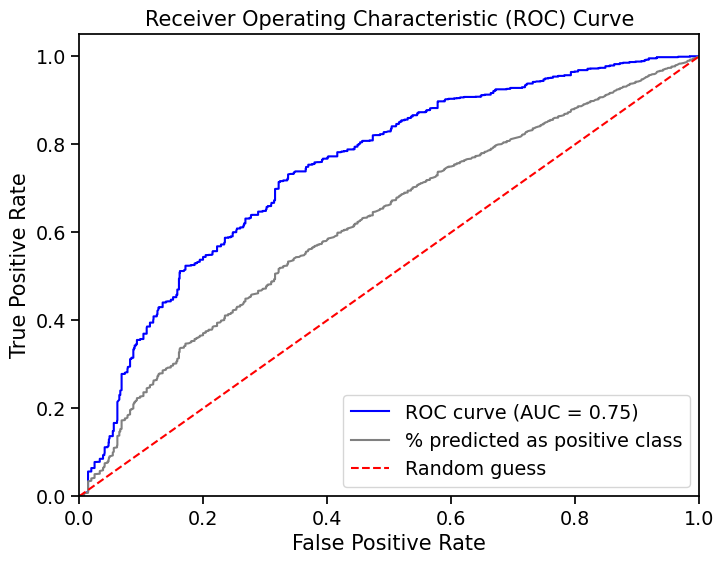

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / len(y_res.values) for thr in thresholds]

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='grey', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [19]:
import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

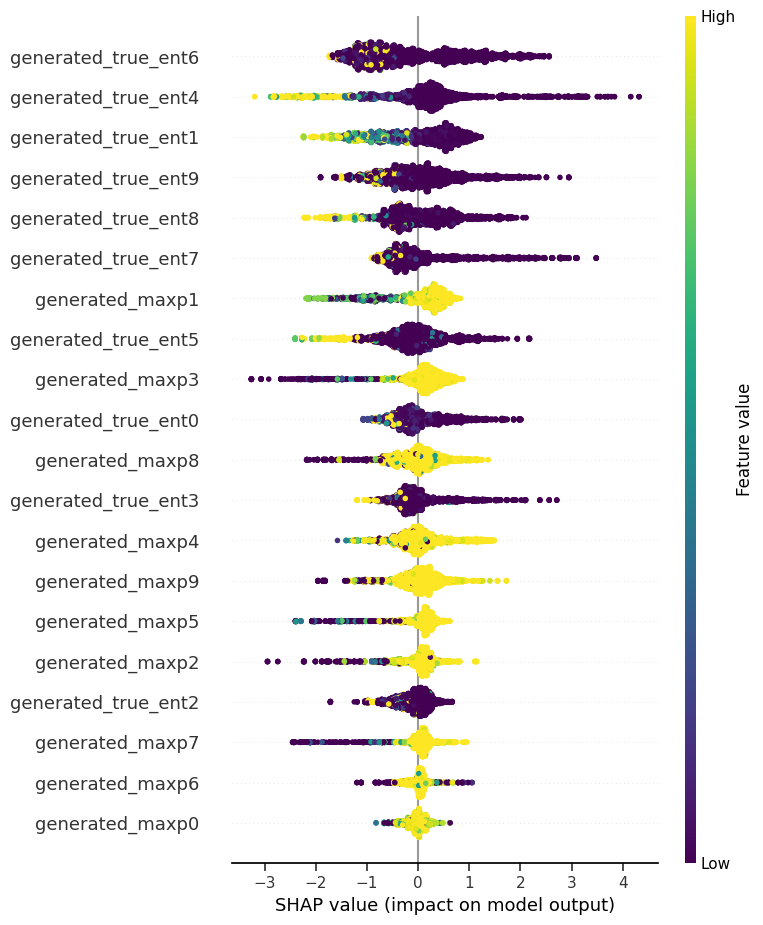

In [20]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [21]:
# shap.plots.heatmap(shap_values, cmap="RdBu_r")

In [22]:
#clustering = shap.utils.hclust(X_res, y_res)
#shap.plots.bar(shap_values, clustering=clustering, max_display=20, clustering_cutoff=1)

In [23]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [24]:
vals.groupby('grp').value.sum()

grp
generated_maxp        0.347742
generated_shape       0.008320
generated_true_ent    0.643937
Name: value, dtype: float64

In [25]:
K = 10
top_feat_generated_begin = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

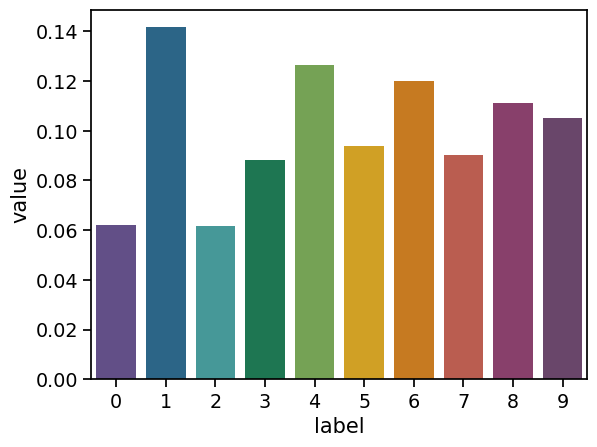

In [26]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(27.44444444444443, 0.5, 'Token index')

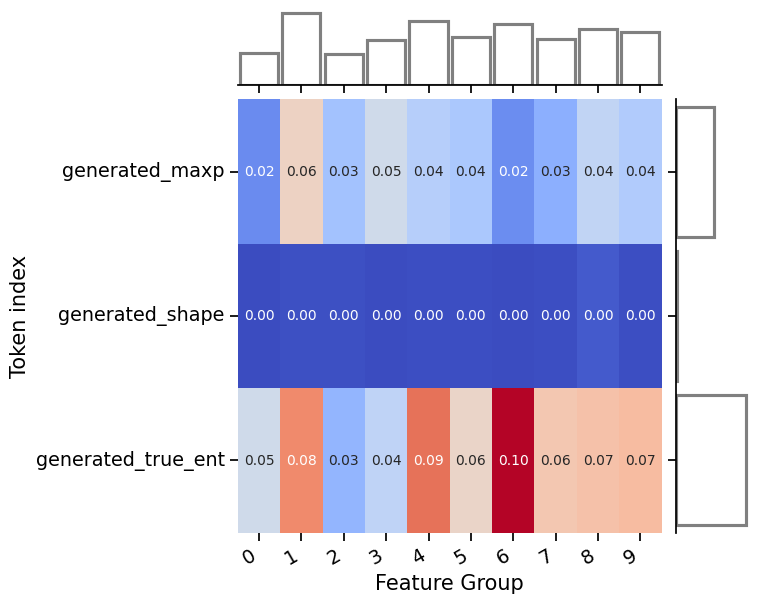

In [27]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### postilla

In [54]:
mm[(mm.segment=='postilla')].tokzero.max()

64

In [55]:
# end of ...
# ds = mm[(mm.segment=='postilla') & (mm.tokzero_end>=-10)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

X_res.columns = ['postilla_'+col for col in X.columns]

In [56]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

CPU times: user 31.1 s, sys: 1.63 s, total: 32.8 s
Wall time: 4.65 s


In [57]:
pred = pred_proba_instr.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.63      0.58      0.60      1903
        True       0.61      0.66      0.63      1903

    accuracy                           0.62      3806
   macro avg       0.62      0.62      0.62      3806
weighted avg       0.62      0.62      0.62      3806



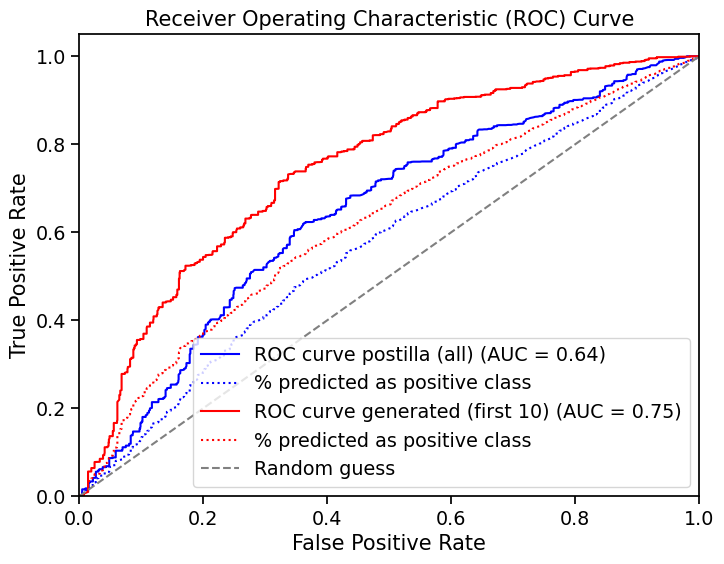

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_instr[:, 1])
true_counts_rel = [(pred_proba_instr[:, 1] > thr).sum() / pred_proba_instr.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [82]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

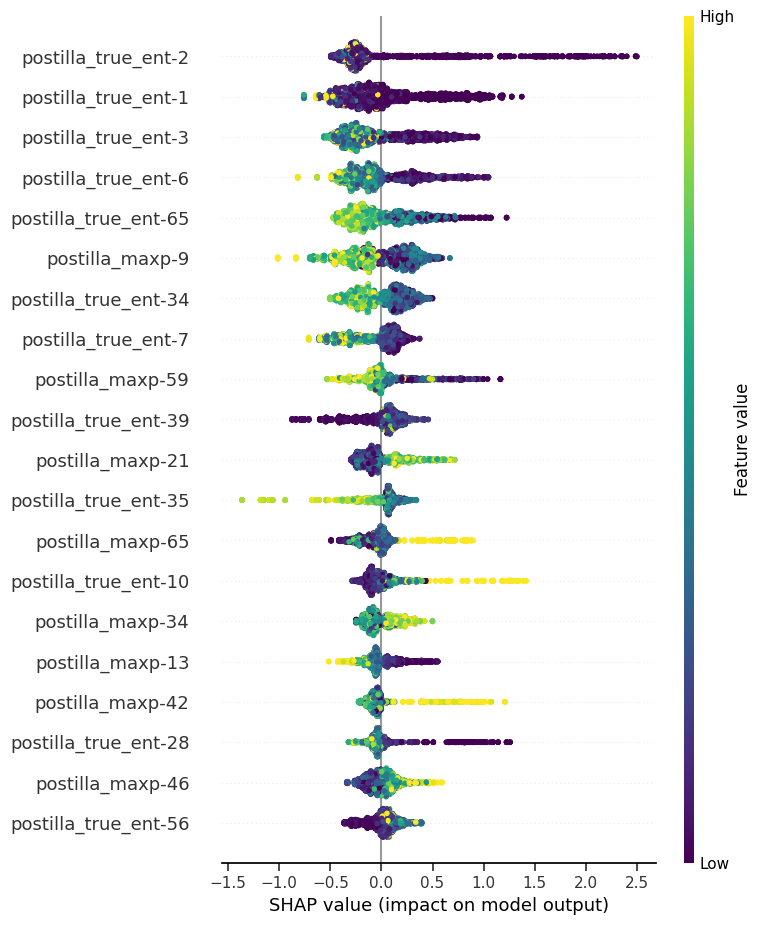

In [83]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [84]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [85]:
K = 10
top_feat_postilla_all = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()

In [86]:
vals.sort_values('value', ascending=False)[:K].value.sum()

0.28062198975174457

In [87]:
vals.groupby('grp').value.sum()

grp
postilla_maxp-        0.354725
postilla_shape-       0.122639
postilla_true_ent-    0.522636
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



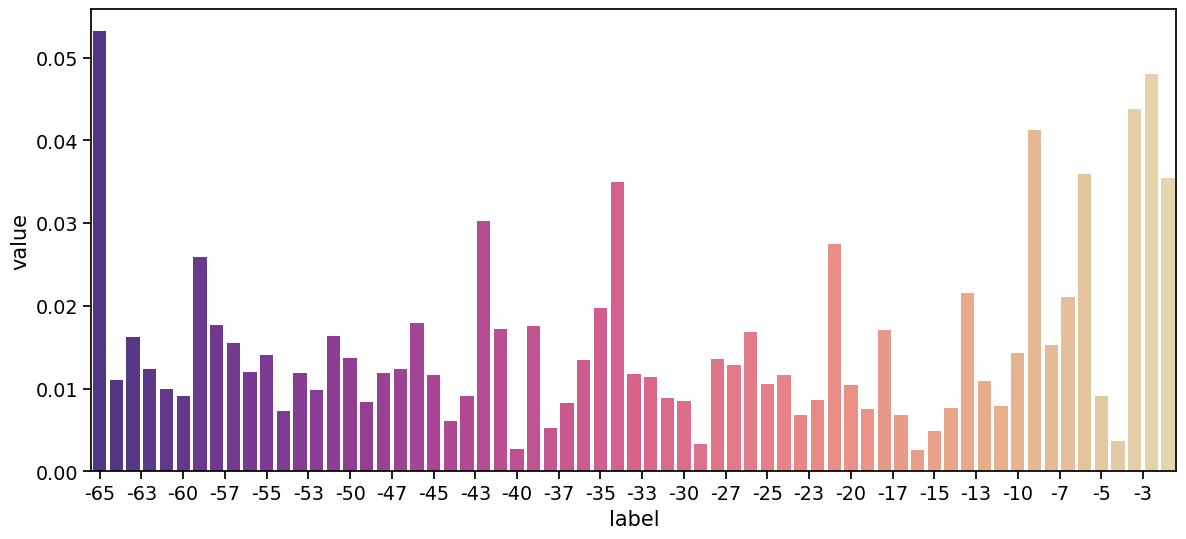

In [88]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

ax.xaxis.set_major_locator(MaxNLocator(nbins=32))

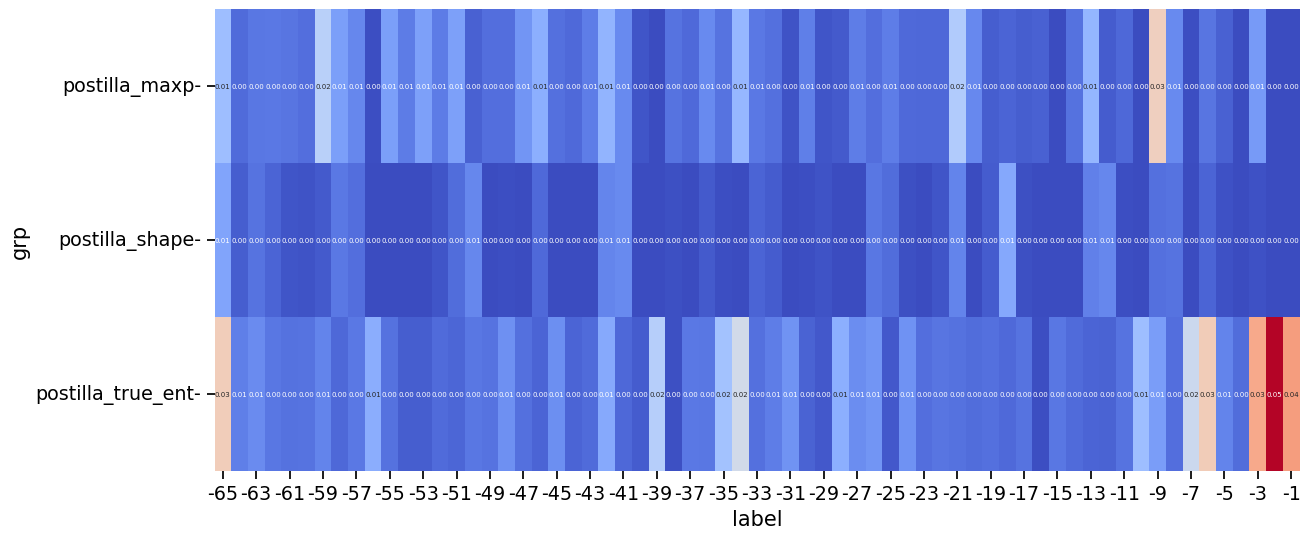

In [89]:
plt.figure(figsize=(14, 6))
_toplot = vals.pivot(index='grp', columns='label', values='value')
ax = plt.gca()
sns.heatmap(_toplot, ax=ax, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":5}, cmap="coolwarm")
plt.show()

### postilla all vs on unique records

In [90]:
# end of ...
# ds = mm[(mm.segment=='postilla') & (mm.tokzero_end>=-10)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-2])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])


# rus = RandomUnderSampler(random_state=42)
X_res_u, y_res_u = X,y # rus.fit_resample(X, y)
pids_res = pids[y_res_u.index]

X_res_u.columns = ['postilla_'+col for col in X.columns]

In [91]:
%%time

# unweighted
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_postilla_unique = cross_val_predict(xgb_model, X_res_u, y_res_u, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

pred = pred_proba_postilla_unique.argmax(axis=1).astype(bool)
print(classification_report(y_res_u.values, pred))


              precision    recall  f1-score   support

       False       0.38      0.10      0.16       178
        True       0.75      0.94      0.83       510

    accuracy                           0.72       688
   macro avg       0.56      0.52      0.50       688
weighted avg       0.65      0.72      0.66       688

CPU times: user 21.7 s, sys: 1.26 s, total: 22.9 s
Wall time: 3.04 s


In [92]:
%%time

# with class weights
class_counts = np.bincount(y_res_u)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res_u])

pred_proba_postilla_unique = cross_val_predict(xgb_model, X_res_u, y_res_u, cv=GroupKFold(n_splits=10), 
                                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

pred = pred_proba_postilla_unique.argmax(axis=1).astype(bool)
print(classification_report(y_res_u.values, pred))

              precision    recall  f1-score   support

       False       0.39      0.39      0.39       178
        True       0.79      0.79      0.79       510

    accuracy                           0.68       688
   macro avg       0.59      0.59      0.59       688
weighted avg       0.68      0.68      0.68       688



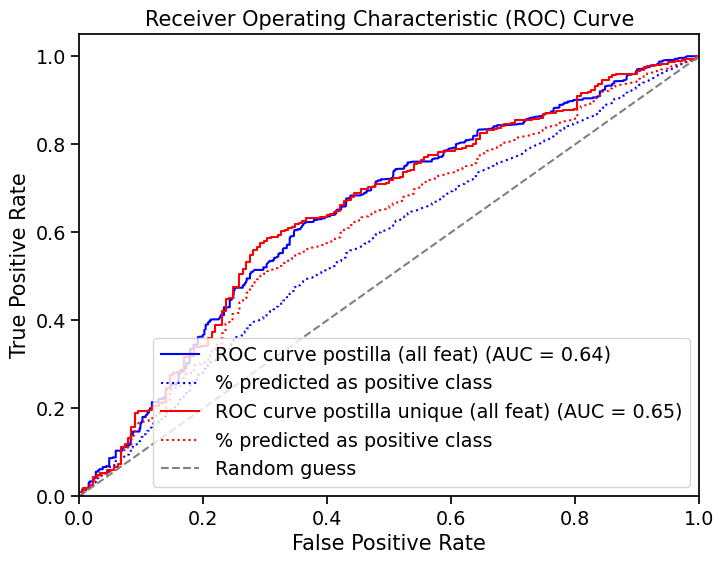

In [93]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_instr[:, 1])
true_counts_rel = [(pred_proba_instr[:, 1] > thr).sum() / pred_proba_instr.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all feat) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_u.values, pred_proba_postilla_unique[:, 1])
true_counts_rel = [(pred_proba_postilla_unique[:, 1] > thr).sum() / pred_proba_postilla_unique.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve postilla unique (all feat) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

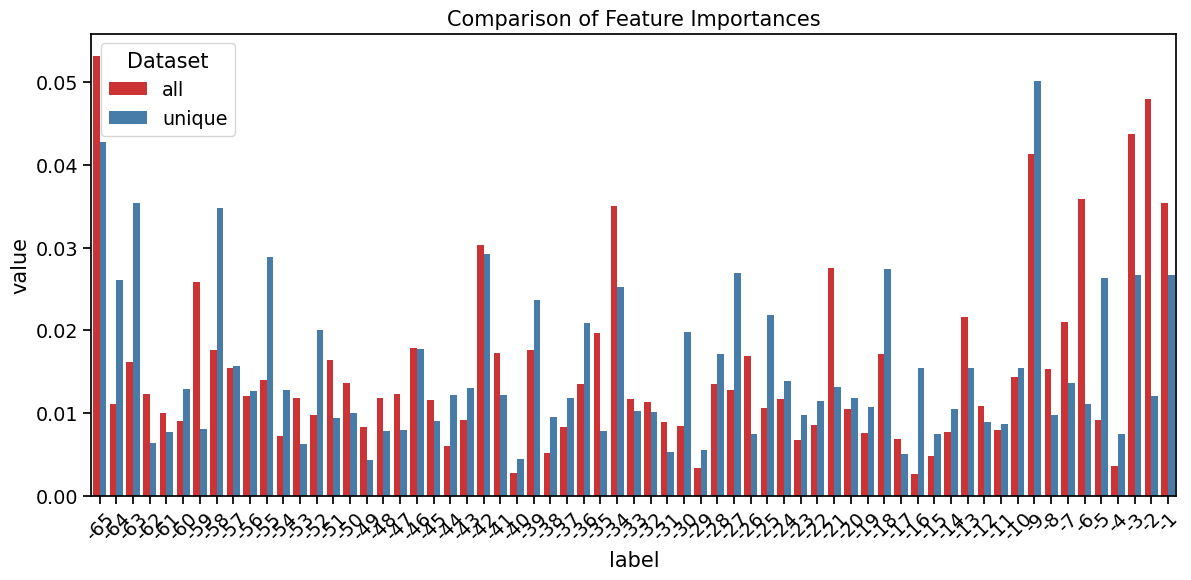

In [97]:
# feature importances when considerin all or unique records for postilla

model = xgboost.XGBClassifier(n_estimators=1000).fit(X_res_u, y_res_u)
explainer = shap.Explainer(model, X_res_u)
shap_values = explainer(X_res_u)

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize

plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances_u = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}

index_importances['dataset'] = 'all'
index_importances_u['dataset'] = 'unique'
combined_df = pd.concat([index_importances, index_importances_u])

ax = sns.barplot(data=combined_df, x='label', y='value', hue='dataset', palette='Set1', dodge=True, ax=ax)

plt.xticks(rotation=45)
plt.title("Comparison of Feature Importances")
plt.legend(title="Dataset")

plt.show()

### combo

In [40]:
# COMBO
# beginning of generate + postilla

ds = mm[(mm.segment=='generated') & (mm.tokzero<=N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds1 = ds.merge(truth, on=['run', 'pid'])
ds1.columns = ['generated_' + col if col[-1].isdigit() else col for col in ds1.columns]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds2 = ds.merge(truth, on=['run', 'pid'])
ds2.columns = ['postilla_' + col if col[-1].isdigit() else col for col in ds2.columns]

In [41]:
ds = ds1.merge(ds2, on = ['run', 'pid', 'correct', 'hallucinated'])

In [42]:
ds.shape, ds1.shape, ds2.shape

((6880, 232), (6880, 37), (6880, 199))

In [43]:
y = ds.correct
pids = ds.pid

X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# SELETC TOP FEATURES ONLY
X = X[top_feat_postilla_all + top_feat_generated_begin]

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

In [44]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
pred_proba_combo = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

CPU times: user 6.31 s, sys: 457 ms, total: 6.77 s
Wall time: 860 ms


In [45]:
pred = pred_proba_combo.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.73      0.59      0.65      1903
        True       0.65      0.78      0.71      1903

    accuracy                           0.68      3806
   macro avg       0.69      0.68      0.68      3806
weighted avg       0.69      0.68      0.68      3806



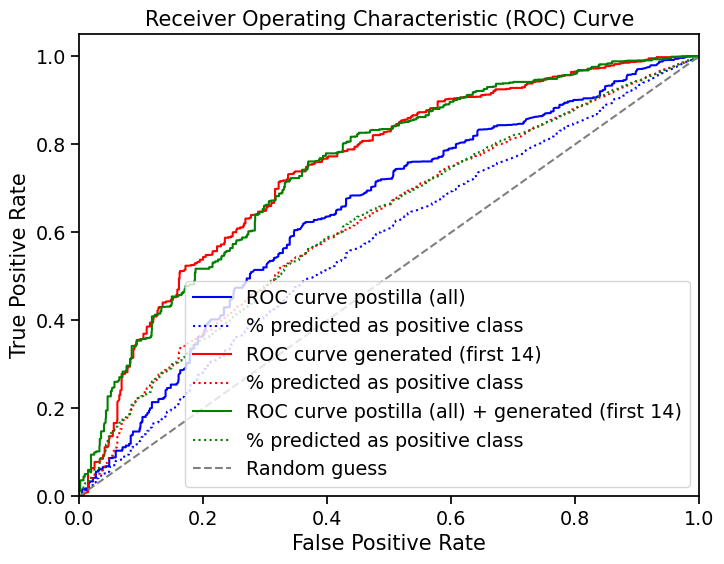

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_instr[:, 1])
true_counts_rel = [(pred_proba_instr[:, 1] > thr).sum() / pred_proba_instr.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all)')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first 14)')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_combo[:, 1])
true_counts_rel = [(pred_proba_combo[:, 1] > thr).sum() / pred_proba_combo.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='green', label=f'ROC curve postilla (all) + generated (first 14)')
plt.plot(fpr, true_counts_rel, color='green', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [47]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [48]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [49]:
vals.groupby('grp').value.sum()

grp
generated_maxp        0.131719
generated_true_ent    0.595327
postilla_maxp-        0.063047
postilla_true_ent-    0.209907
Name: value, dtype: float64

In [50]:
vals

,label,value,label_orig,grp
10,6,0.109224,generated_true_ent6,generated_true_ent
11,4,0.096896,generated_true_ent4,generated_true_ent
14,8,0.082960,generated_true_ent8,generated_true_ent
13,9,0.079777,generated_true_ent9,generated_true_ent
18,3,0.072548,generated_maxp3,generated_maxp
15,7,0.069377,generated_true_ent7,generated_true_ent
17,5,0.067224,generated_true_ent5,generated_true_ent
16,1,0.059171,generated_maxp1,generated_maxp
12,1,0.057961,generated_true_ent1,generated_true_ent
5,-9,0.043573,postilla_maxp-9,postilla_maxp-




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

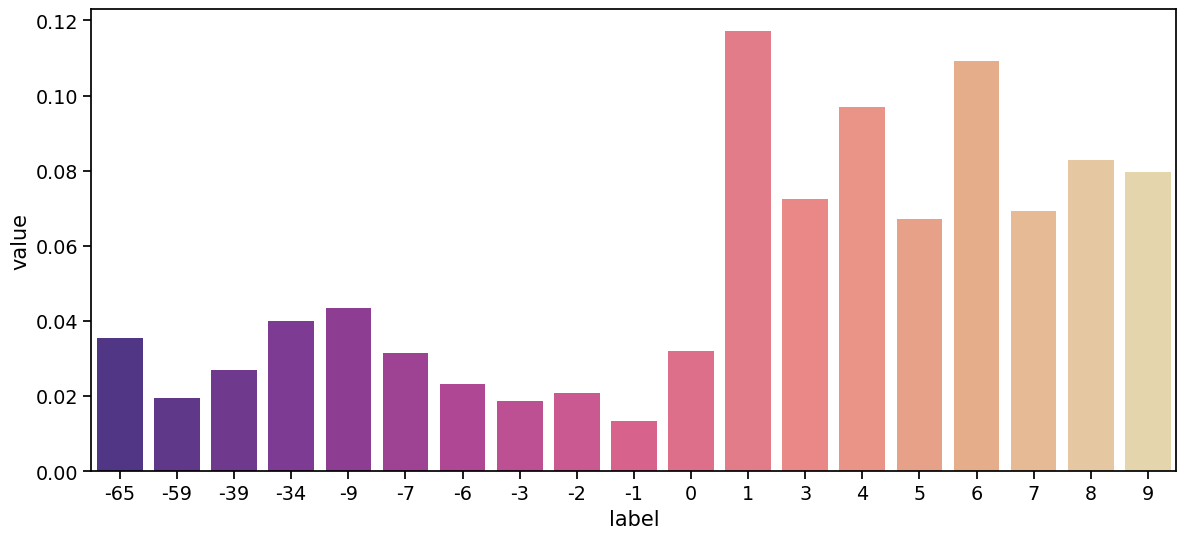

In [51]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

# ax.xaxis.set_major_locator(MaxNLocator(nbins=32))

Text(27.44444444444443, 0.5, 'Token index')

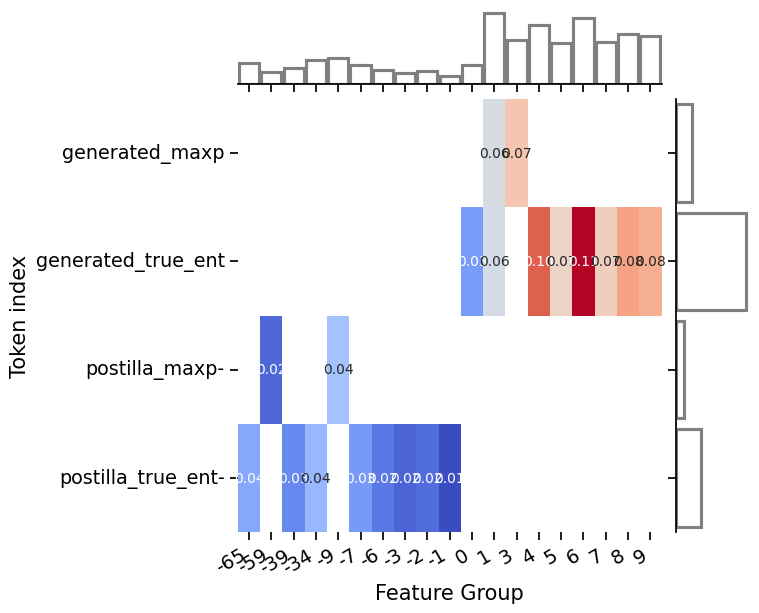

In [52]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### end of input (no candidates provided yet)

In [53]:
mm.head()

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
0,0,9,0,prompt,19127,9.342692,0.011505,0,40,preamble,0,40,0.000,0.000,0,-41
6,0,9,1,prompt,4954,6.863560,0.110962,0,40,preamble,0,40,0.025,0.025,1,-40
12,0,9,2,prompt,9,1.748911,0.684082,0,40,preamble,0,40,0.050,0.050,2,-39
18,0,9,3,prompt,178,4.617726,0.093811,0,40,preamble,0,40,0.075,0.075,3,-38
24,0,9,4,prompt,5,1.100033,0.811523,0,40,preamble,0,40,0.100,0.100,4,-37


In [54]:
# end of input (last NN)
NN = 64
ds = mm[(mm.segment=='input') & (mm.tokzero_end>=-NN)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

X_res.columns = ['input_'+col for col in X.columns]

In [55]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_input = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

pred = pred_proba_input.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.53      0.44      0.48      1903
        True       0.52      0.62      0.57      1903

    accuracy                           0.53      3806
   macro avg       0.53      0.53      0.52      3806
weighted avg       0.53      0.53      0.52      3806

CPU times: user 26.4 s, sys: 1.34 s, total: 27.8 s
Wall time: 3.84 s


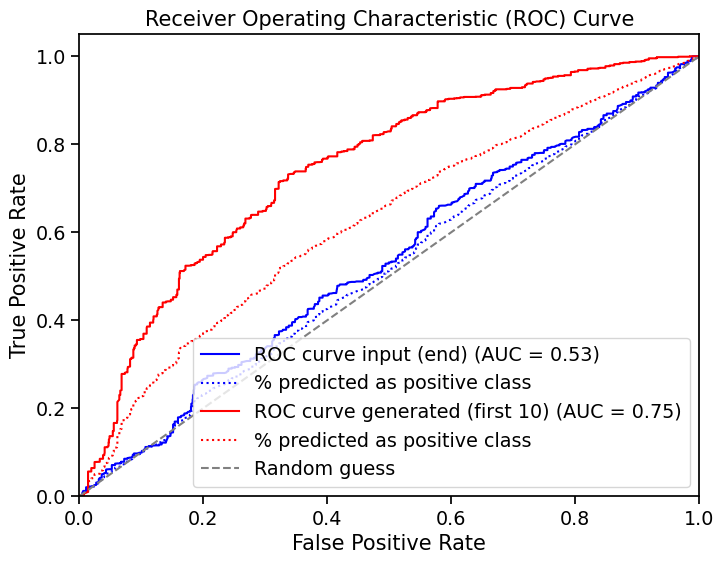

In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_input[:, 1])
true_counts_rel = [(pred_proba_input[:, 1] > thr).sum() / pred_proba_input.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve input (end) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### does adding candidate distance measures add information? (likely no)

In [57]:
# candidate measures are known at runtime and constant for each prompt

In [58]:
with open('aggrodue.pickle', 'rb') as handle:
    aggrodue = pickle.load(handle)

In [84]:
N = 2
#ds = mm[(mm.segment=='generated') & (mm.tokzero<N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

ds = ds[ds.pid.isin(aggrodue.pid.unique())] # something got lost on the way?

In [85]:
# % of prompts showing variance in output across runs (selected features)
(ds.groupby('pid').std() != 0.).sum() / ds.pid.nunique()

run             1.000000
maxp0           0.000000
maxp1           0.000000
maxp2           0.000000
maxp3           0.000000
                  ...   
true_ent62      0.000000
true_ent63      0.000000
true_ent64      0.000000
correct         0.351351
hallucinated    0.015015
Length: 133, dtype: float64

In [86]:
# WARNING only unique observations
ds = ds.drop_duplicates(ds.columns[1:-2])

In [87]:
ds.shape

(666, 134)

In [88]:
ds.correct.value_counts()

correct
True     490
False    176
Name: count, dtype: int64

In [89]:
# check variances

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

In [90]:
X_res.shape

(352, 132)

In [91]:
y_res.value_counts()

correct
False    176
True     176
Name: count, dtype: int64

In [92]:
(X_res.groupby('pid').std() != 0.).sum() / X_res.pid.nunique()

maxp0         1.0
maxp1         1.0
maxp2         1.0
maxp3         1.0
maxp4         1.0
             ... 
true_ent61    1.0
true_ent62    1.0
true_ent63    1.0
true_ent64    1.0
correct       1.0
Length: 131, dtype: float64

In [93]:
# dataset 

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

print(X.shape, y.sum())

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]
X_res.columns

(666, 130) 490


Index(['generated_maxp0', 'generated_maxp1', 'generated_maxp2',
       'generated_maxp3', 'generated_maxp4', 'generated_maxp5',
       'generated_maxp6', 'generated_maxp7', 'generated_maxp8',
       'generated_maxp9',
       ...
       'generated_true_ent55', 'generated_true_ent56', 'generated_true_ent57',
       'generated_true_ent58', 'generated_true_ent59', 'generated_true_ent60',
       'generated_true_ent61', 'generated_true_ent62', 'generated_true_ent63',
       'generated_true_ent64'],
      dtype='object', length=130)

In [94]:
X_res.shape, y_res.shape

((352, 130), (352,))

In [95]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.61      0.60      0.60       176
        True       0.60      0.61      0.61       176

    accuracy                           0.61       352
   macro avg       0.61      0.61      0.61       352
weighted avg       0.61      0.61      0.61       352

CPU times: user 15.7 s, sys: 1.4 s, total: 17.1 s
Wall time: 2.28 s


In [96]:
# dataset with candidate measures

add = aggrodue[['pid', 'cand_average_dist_mean', 'cand_max_dist_mean', 'cand_average_jaccard_dist_mean', 'cand_average_jaccard_tok_dist_mean']]
add = add.rename(columns={'cand_average_dist_mean': 'cand_average_dist_mean999', 
                          'cand_max_dist_mean': 'cand_max_dist_mean999', 
                          'cand_average_jaccard_dist_mean': 'cand_average_jaccard_dist_mean999',
                          'cand_average_jaccard_tok_dist_mean': 'cand_average_jaccard_tok_dist_mean999'})
ds_ = ds.merge(add, on='pid')

y = ds_.correct
pids = ds_.pid
X = ds_.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

print(X.shape, y.sum())

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]
X_res.columns

(666, 134) 490


Index(['generated_maxp0', 'generated_maxp1', 'generated_maxp2',
       'generated_maxp3', 'generated_maxp4', 'generated_maxp5',
       'generated_maxp6', 'generated_maxp7', 'generated_maxp8',
       'generated_maxp9',
       ...
       'generated_true_ent59', 'generated_true_ent60', 'generated_true_ent61',
       'generated_true_ent62', 'generated_true_ent63', 'generated_true_ent64',
       'generated_cand_average_dist_mean999',
       'generated_cand_max_dist_mean999',
       'generated_cand_average_jaccard_dist_mean999',
       'generated_cand_average_jaccard_tok_dist_mean999'],
      dtype='object', length=134)

In [97]:
X_res.shape, y_res.shape

((352, 134), (352,))

In [98]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba2 = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

pred2 = pred_proba2.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred2))

              precision    recall  f1-score   support

       False       0.59      0.60      0.60       176
        True       0.60      0.59      0.59       176

    accuracy                           0.59       352
   macro avg       0.59      0.59      0.59       352
weighted avg       0.59      0.59      0.59       352

CPU times: user 16.4 s, sys: 863 ms, total: 17.2 s
Wall time: 2.21 s


In [99]:
import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [100]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [101]:
vals

,label,value,label_orig,grp
56,56,0.063996,generated_maxp56,generated_maxp
124,59,0.045229,generated_true_ent59,generated_true_ent
23,23,0.039796,generated_maxp23,generated_maxp
129,64,0.038912,generated_true_ent64,generated_true_ent
128,63,0.028456,generated_true_ent63,generated_true_ent
...,...,...,...,...
63,63,0.000000,generated_maxp63,generated_maxp
25,25,0.000000,generated_maxp25,generated_maxp
9,9,0.000000,generated_maxp9,generated_maxp
26,26,0.000000,generated_maxp26,generated_maxp




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


The palette list has fewer values (10) than needed (66) and will cycle, which may produce an uninterpretable plot.


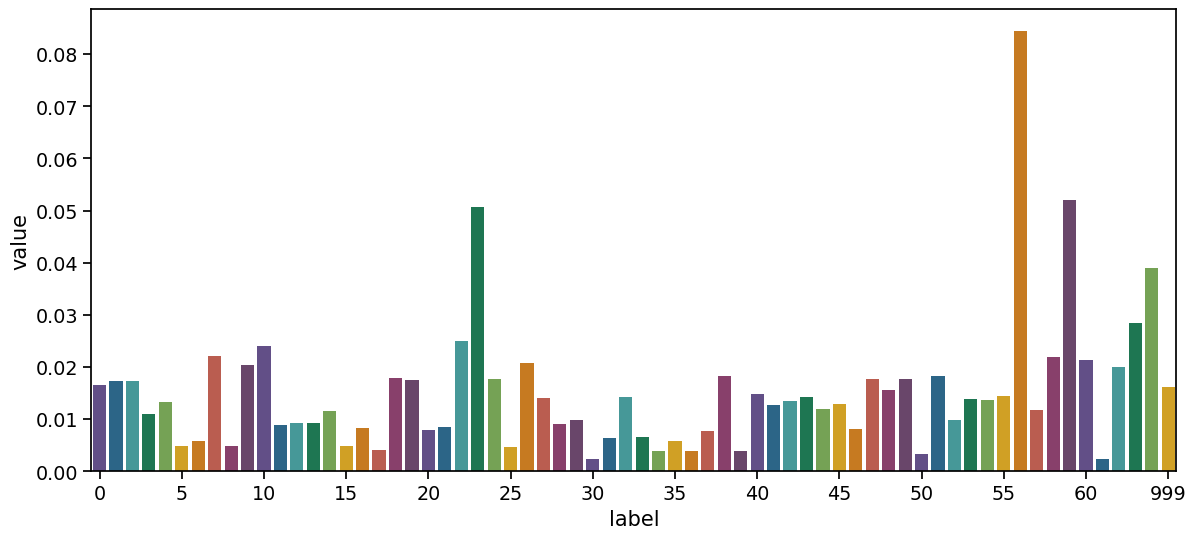

In [105]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

plt.figure(figsize=(14, 6))
ax = plt.gca()
sns.barplot(index_importances, palette=palette,ax=ax)

ax.xaxis.set_major_locator(MaxNLocator(nbins=16))

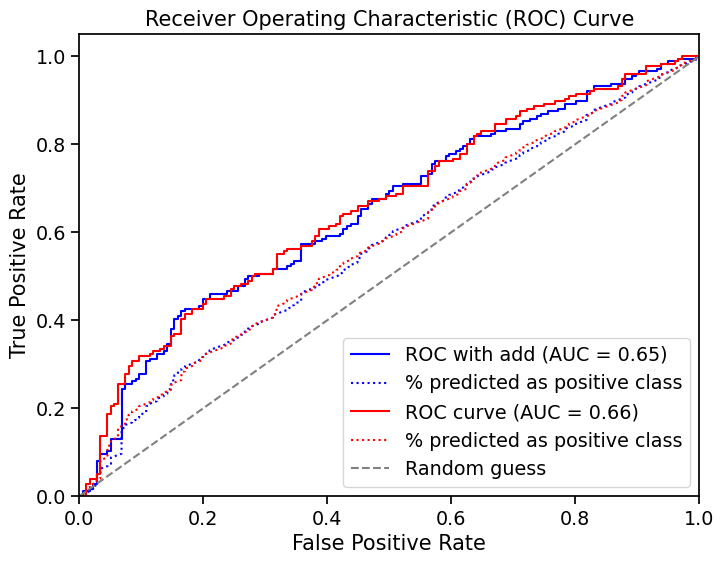

In [103]:
# compare with and without candidate measures

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba2[:, 1])
true_counts_rel = [(pred_proba2[:, 1] > thr).sum() / pred_proba2.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC with add (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()